In [1]:
import os

import torch
# import torchvision
from torchvision.transforms import v2

# from torch import nn
# from torchsummary import summary

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from PIL import Image
import tqdm.notebook as tqdm

%load_ext autoreload

from data_loaders import *
%autoreload 2
from training_utils import *
%autoreload 2
from cnn_model import *
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

<Figure size 500x500 with 0 Axes>

In [40]:
test_prop = 0.3
val_prop = 0.2

batch_size = 64

# img_type = 'raw-derivative.-60'
# img_type = 'raw-original'
# img_type = 'raw-fft'

In [41]:
# Creating the datasets

transform = v2.Compose([
    v2.ToTensor(),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.Normalize(mean=[0], std=[67]),
    # v2.Normalize(mean=[0, 150], std=[100, 100]),

    v2.ToDtype(torch.float, scale=True),
    # v2.ColorJitter(0.5, None, None, None),
    # v2.GaussianBlur(kernel_size=(5, 5), sigma=(0.2, 0.5))
])

target_transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=[0], std=[67]),
    # v2.Normalize(mean=[0, 150], std=[100, 100]),
    v2.ToDtype(torch.float, scale=True),
    # v2.ColorJitter(0.5, None, None, None),
    # v2.GaussianBlur(kernel_size=(5, 5), sigma=(0.2, 0.5))
])


train_labeled_data = CloudDetectionTrain(
    transform=transform
)

test_labeled_data = CloudDetectionTrain(
    target_transform=target_transform
)

pano_df = train_labeled_data.dataset_manager.main_dfs['pano']
feature_df = train_labeled_data.dataset_manager.main_dfs['feature']
feature_merged_df = feature_df.reset_index().merge(pano_df, on = 'pano_uid').set_index('index')
dsl_merged = feature_merged_df.merge(train_labeled_data.dsl_df, on = 'feature_uid').reset_index()

In [42]:
def data_split(test_prop, val_prop, batch_id, boundary_prop=0.2):
    assert 0 <= test_prop <= 1, 0 <= val_prop <= 1
    batch_data = dsl_merged[dsl_merged['batch_id_x'] == batch_id].sort_values(by = 'frame_unix_t')
    
    test_split = int(len(batch_data) * test_prop)
    ntrain = len(batch_data) - test_split
    val_split = int(ntrain * val_prop)
    boundary_cnt = int((len(batch_data) - val_split) * boundary_prop)
    
    test_idx = batch_data[:test_split].index.values
    val_idx = batch_data[test_split: test_split + val_split].index.values
    train_idx = batch_data[test_split + val_split + boundary_cnt:].index.values
    
    return test_idx, val_idx, train_idx

def get_windowed_test_val_train_indices(test_prop, val_prop):
    test_indices = np.array([], dtype=np.int64)
    val_indices = np.array([], dtype=np.int64)
    train_indices = np.array([], dtype=np.int64)

    for batch_id in pano_df['batch_id'].unique():
        test_idx, val_idx, train_idx = data_split(test_prop, val_prop, batch_id)
        test_indices = np.concatenate((test_indices, test_idx))
        val_indices = np.concatenate((val_indices, val_idx))
        train_indices = np.concatenate((train_indices, train_idx))
    return test_indices, val_indices, train_indices

def get_shuffled_test_val_train_indices(test_prop, val_prop):
    dataset_size = len(dsl_merged)
    dataset_indices = np.arange(dataset_size)
    
    np.random.shuffle(dataset_indices)
    
    # Test / Train split
    test_split_index = int(np.floor(test_prop * dataset_size))
    trainset_indices, test_idx = dataset_indices[test_split_index:], dataset_indices[:test_split_index]
    
    # Train / Val split
    trainset_size = len(trainset_indices)
    val_split_index = int(np.floor(val_prop * trainset_size))
    train_idx, val_idx = trainset_indices[val_split_index:], trainset_indices[:val_split_index]
    return test_idx, val_idx, train_idx

In [43]:
dataset_size = len(dsl_merged)

# test_idx, val_idx, train_idx = get_windowed_test_val_train_indices(test_prop, val_prop)
test_idx, val_idx, train_idx = get_shuffled_test_val_train_indices(test_prop, val_prop)
# print(test_idx, val_idx, train_idx)

test_loader = torch.utils.data.DataLoader(
  dataset=test_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(test_idx)
)

train_loader = torch.utils.data.DataLoader(
  dataset=train_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(train_idx)
)

val_loader = torch.utils.data.DataLoader(
  dataset=train_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.sampler.SubsetRandomSampler(val_idx)
)


# Get dataset stats

print(f'test_prop = {100 * len(test_idx) / dataset_size:.2f}%\n'
      f'train_prop = {100 * len(train_idx) / dataset_size:.2f}%\n'
      f'val_prop = {100 * len(val_idx) / dataset_size:.2f}%'
)
# feature_uid = train_labeled_data.dsl_df.loc[:, 'feature_uid'].iloc[0]
# train_labeled_data[0][0]
def print_class_dist(data, idx, name):
    filtered_data = data.iloc[idx]
    num_clear = len(filtered_data.loc[filtered_data['label'] == 'clear_night_sky'])
    num_cloudy = len(filtered_data.loc[filtered_data['label'] == 'not_clear_cloudy'])
    print(f'Percent cloudy (in {name}) = {100 *num_cloudy / len(filtered_data):.3f}% ({num_cloudy} / {len(filtered_data)})')

print_class_dist(dsl_merged, test_idx, 'test')
print_class_dist(dsl_merged, val_idx, 'val')
print_class_dist(dsl_merged, train_idx, 'train')
print_class_dist(dsl_merged, dsl_merged.index, 'overall')

test_prop = 29.99%
train_prop = 56.01%
val_prop = 14.00%
Percent cloudy (in test) = 54.718% (1444 / 2639)
Percent cloudy (in val) = 55.844% (688 / 1232)
Percent cloudy (in train) = 55.032% (2712 / 4928)
Percent cloudy (in overall) = 55.052% (4844 / 8799)


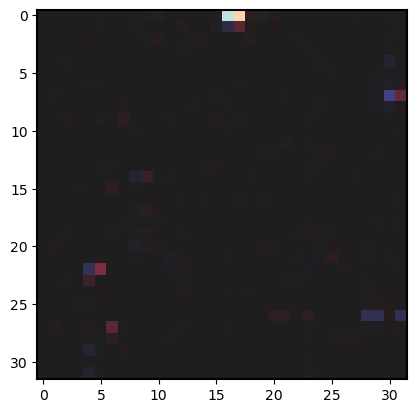

In [39]:
import time
from IPython import display

try:
    idx = np.random.choice(len(train_labeled_data), size=1000, replace=False)
    for i in idx:
        img = train_labeled_data[i]
        plt.imshow(img[0][0], vmin=-2, vmax=2, cmap='icefire')
        plt.show()
        plt.close()
        time.sleep(.05)
        display.clear_output(wait=True)
except KeyboardInterrupt:
    plt.close()

In [49]:
# Training config

learning_rate = 0.001
# momentum=0.9

model = CloudDetection()

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-6)#, momentum=momentum)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()

trainer = Trainer(
    model, optimizer, loss_fn, train_loader, val_loader,
    epochs=12, gamma=0.9, do_summary=True,
    # img_type=img_type
);

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 48, 10, 10]          --
|    └─Conv2d: 2-1                       [-1, 48, 32, 32]          480
|    └─ReLU: 2-2                         [-1, 48, 32, 32]          --
|    └─BatchNorm2d: 2-3                  [-1, 48, 32, 32]          96
|    └─Dropout2d: 2-4                    [-1, 48, 32, 32]          --
|    └─Conv2d: 2-5                       [-1, 48, 32, 32]          20,784
|    └─ReLU: 2-6                         [-1, 48, 32, 32]          --
|    └─BatchNorm2d: 2-7                  [-1, 48, 32, 32]          96
|    └─Dropout2d: 2-8                    [-1, 48, 32, 32]          --
|    └─Conv2d: 2-9                       [-1, 48, 32, 32]          20,784
|    └─ReLU: 2-10                        [-1, 48, 32, 32]          --
|    └─BatchNorm2d: 2-11                 [-1, 48, 32, 32]          96
|    └─MaxPool2d: 2-12                   [-1, 48, 10, 10]          --
|    └



Epoch 1


  0%|          | 0/77 [00:00<?, ?batches/s]

       Val: 	loss = 0.5855,  acc = 1047/1232 (84.98%) 
      Train: 	loss = 0.5910,  acc = 4093/4928 (83.06%)


Epoch 2


  0%|          | 0/77 [00:00<?, ?batches/s]

       Val: 	loss = 0.5090,  acc = 1116/1232 (90.58%) 
      Train: 	loss = 0.5164,  acc = 4402/4928 (89.33%)


Epoch 3


  0%|          | 0/77 [00:00<?, ?batches/s]

       Val: 	loss = 0.4806,  acc = 1097/1232 (89.04%) 
      Train: 	loss = 0.4910,  acc = 4268/4928 (86.61%)


Epoch 4


  0%|          | 0/77 [00:00<?, ?batches/s]

       Val: 	loss = 0.4123,  acc = 1142/1232 (92.69%) 
      Train: 	loss = 0.4241,  acc = 4472/4928 (90.75%)


Epoch 5


  0%|          | 0/77 [00:00<?, ?batches/s]

       Val: 	loss = 0.3923,  acc = 1165/1232 (94.56%) 
      Train: 	loss = 0.4042,  acc = 4592/4928 (93.18%)


Epoch 6


  0%|          | 0/77 [00:00<?, ?batches/s]

       Val: 	loss = 0.3856,  acc = 1170/1232 (94.97%) 
      Train: 	loss = 0.3978,  acc = 4610/4928 (93.55%)


Epoch 7


  0%|          | 0/77 [00:00<?, ?batches/s]

       Val: 	loss = 0.3884,  acc = 1172/1232 (95.13%) 
      Train: 	loss = 0.4011,  acc = 4643/4928 (94.22%)


Epoch 8


  0%|          | 0/77 [00:00<?, ?batches/s]

       Val: 	loss = 0.3774,  acc = 1179/1232 (95.70%) 
      Train: 	loss = 0.3906,  acc = 4655/4928 (94.46%)


Epoch 9


  0%|          | 0/77 [00:00<?, ?batches/s]

       Val: 	loss = 0.3616,  acc = 1170/1232 (94.97%) 
      Train: 	loss = 0.3738,  acc = 4632/4928 (93.99%)


Epoch 10


  0%|          | 0/77 [00:00<?, ?batches/s]

       Val: 	loss = 0.3664,  acc = 1182/1232 (95.94%) 
      Train: 	loss = 0.3793,  acc = 4683/4928 (95.03%)


Epoch 11


  0%|          | 0/77 [00:00<?, ?batches/s]

       Val: 	loss = 0.3863,  acc = 1183/1232 (96.02%) 
      Train: 	loss = 0.3967,  acc = 4677/4928 (94.91%)


Epoch 12


  0%|          | 0/77 [00:00<?, ?batches/s]

       Val: 	loss = 0.3517,  acc = 1188/1232 (96.43%) 
      Train: 	loss = 0.3633,  acc = 4694/4928 (95.25%)
Done training


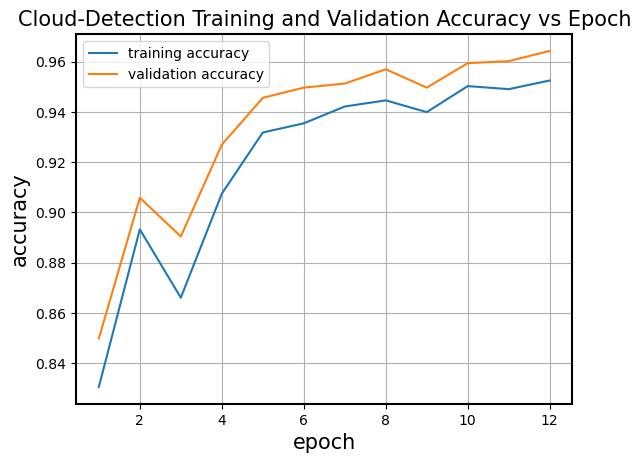

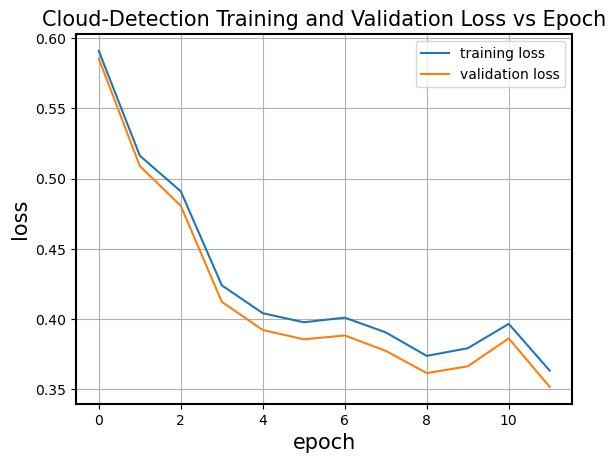

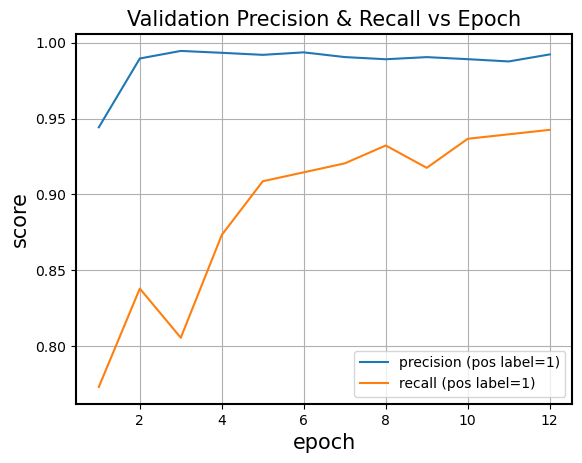

In [50]:
trainer.train()

  0%|          | 0/42 [00:00<?, ?batches/s]

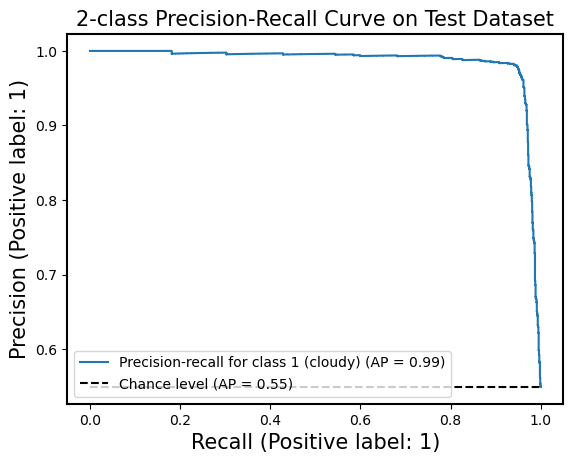

Test: 	loss = 0.3679,  acc = 2497/2639 (94.62%)


In [51]:
tester = Tester(model, loss_fn, test_loader)
tester.eval()

  0%|          | 0/42 [00:00<?, ?batches/s]

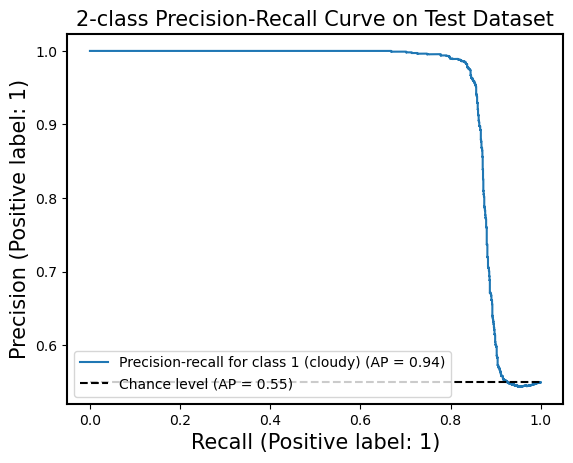

Test: 	loss = 0.3634,  acc = 2516/2639 (95.34%)


In [48]:
model.load_state_dict(torch.load('../model_training/best_cloud_detection_model.pth'))
tester = Tester(model, loss_fn, test_loader)
tester.eval()